<a href="https://colab.research.google.com/github/TheMrGhostman/NeuroEvolution_for_simple_games/blob/master/NeruoEvolution_BipedalWalker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install box2d-py

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import random
from copy import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import gym

# Definition of classes

In [0]:
class Net(nn.Module):
    def __init__(self, in_,  out_, activation=nn.Tanh()):
        super(Net, self).__init__()
        self.in_ = in_
        self.out_ = out_
        self.module_list = [in_, 160,160,160, out_]
        self.model = self.setup_model(activation)
        self.n_weights = self.sum_parameters(self.model)

    @staticmethod
    def sum_parameters(model):
        def prod(array):
            array = np.array(array)
            return array.prod()
        n_params = 0
        for param in model.parameters():
            n_params += prod(param.shape)
        return n_params
    
    def setup_model(self, activation):
        od = {}
        for i in range(len(self.module_list)-1):
            od[f"layer_{i}"] = nn.Linear(self.module_list[i], self.module_list[i+1], bias=False)
            if i!=len(self.module_list)-2:
                od[f"activation_{i}"] = activation
        model = nn.Sequential(OrderedDict(od))
        for params in model.parameters():
            params.requires_grad=False
        return model

    def forward(self, x):
        return self.model(x)

In [0]:
class Agent(object):
    def __init__(self, state_space, action_space):
        self.state_space = state_space
        self.action_space = action_space
        self.brain = Net(in_=state_space, out_=action_space)
        self.n_genes = self.brain.n_weights
        # agents memory
        self.reached_score = 0
        self.new_state = None
        self.done = False


    def act(self, state):
        predicted_action = torch.sigmoid(self.brain(state))
        return predicted_action
    
    def act_from_memory(self, argmax=False):
        if argmax:
            return torch.argmax(self.brain(torch.tensor(self.new_state).float()))
        else:
            return torch.sigmoid(self.brain(torch.tensor(self.new_state).float()))

    def update_agent(self, NsRD_):
        self.new_state = NsRD_[0]
        self.reached_score += NsRD_[1]
        self.done = NsRD_[2]

    @staticmethod
    def prod(array):
        array = np.array(array)
        return array.prod()

    def get_gene(self):
        gene = []
        config_size = []
        config_idx = []
        for param in self.brain.parameters():
            pr = int(self.prod(param.shape))
            config_size.append(param.shape)
            config_idx.append(pr)
            gene.append(param.view(pr))
        config_idx = np.cumsum(config_idx)
        config = [(size, idx) for size, idx in zip(config_size, config_idx)]
        gene = torch.cat(gene)
        return gene, config

    def set_gene(self, gene, config):
        config.insert(0, (0, 0))
        for i, param in enumerate(self.brain.parameters()):
            param = gene[config[i][1]:config[i+1][1]].view(config[i+1][0])
        return self


In [0]:
class Population(object):
    def __init__(self, n_agents, state_space, action_space):
        """
        m_agents should be divisible with 2 without remainder 
        """
        self.n_agents = n_agents
        self.population = self.create_population(n_agents, state_space, action_space)
        self.scores_per_generation = {"min":[], "max":[], "mean":[], "std":[]}

    @staticmethod
    def create_population(n_agents, state_space, action_space):
        pop = []
        for i in range(n_agents):
            pop.append(Agent(state_space=state_space, action_space=action_space))
        return pop

    @staticmethod
    def mating(A, B):
        A_gene, A_config = A.get_gene()
        B_gene, B_config = A.get_gene()
        idx = np.random.randint(low=0, high=A_gene.shape[0])
        A_gene_new = torch.cat((A_gene[:idx], B_gene[idx:]))
        B_gene_new = torch.cat((B_gene[:idx], A_gene[idx:]))
        A.set_gene(A_gene_new, A_config)
        B.set_gene(B_gene_new, B_config)
        return A, B
    
    @staticmethod
    def mutation(A, probability, sigma=1):
        A_gene, A_config = A.get_gene()
        # prepeare gaussian generation -> x~N(0, 1) ...... sigma*x + mu ~ N(mu, sigma)
        mut = torch.randn_like(A_gene)
        # select weights which will change
        b = torch.distributions.Bernoulli(probs=probability*torch.ones_like(A_gene)).sample()
        # final mutation
        A_gene = A_gene + sigma*mut*b
        A.set_gene(A_gene, A_config)
        return A

    def optimizatin_loop(self, envs, n_generations, repeats=3, use_argmax=True, probability=0.1, sigma=1, replace=False):
        for generation in tqdm(range(n_generations)):
            scores = []
            # reset
            for i in range(repeats):
                for agent, env in zip(self.population, envs):
                    # reset enviroment
                    agent.new_state = env.reset()
                    # reset reached score
                    agent.reached_score = 0
                    agent.done=False
                
                # evaluation fitness function
                for s in range(500):
                    for agent, env in zip(self.population, envs):
                        if agent.done:
                            continue
                        else:
                            # argmax
                            act = np.array(agent.act_from_memory(argmax=use_argmax))
                            agent.update_agent(env.step(act))
                # appending score
                scores.append(np.array([agent.reached_score for agent in self.population]))

            # complete evaluation in generation
            scores = np.vstack(scores).mean(axis=0) # mean score of through repeats
            # loging results
            self.scores_per_generation["min"].append(np.min(scores))
            self.scores_per_generation["max"].append(np.max(scores))
            self.scores_per_generation["mean"].append(np.mean(scores))
            self.scores_per_generation["std"].append(np.std(scores))
                
            # i want to return last evaluated generation
            if generation==n_generations-1:
                break
            else:
                # sort population according to fitness (score) and sort score
                # self.population = [pop for (_, pop) in sorted(zip(np.array(scores), self.population), reverse=True)]  
                #       => somehow it does not work becouse of TypeError: '<' not supported between instances of 'Agent' and 'Agent'
                tmp = [idx for (_, idx) in sorted(zip(np.array(scores), np.arange(self.n_agents)), reverse=True)]
                self.population = [self.population[i] for i in tmp]
                scores = sorted(scores, reverse=True)
                # save best agent
                self.best_agent = self.population[0]

                # scale scores MinMaxScaler
                scaled_scores = (scores - np.min(scores))/(np.max(scores)-np.min(scores))
                # scaled scores to probability
                scaled_scores = scaled_scores/np.sum(scaled_scores)

                # Roulette wheel selection
                chosen_pairs = np.random.choice(self.population, size= int(self.n_agents/2)//2*2, replace=replace, p=scaled_scores).tolist() # => fix for both negatives and positives
                # I want half of current generation to be chosen and divisible with 2 without remainder
                # agents are already shuffled so i can pair them now -> random pairing
                new_pop = []
                for i in range(0,len(chosen_pairs), 2):
                    A, B = self.mating(chosen_pairs[i], chosen_pairs[i+1])
                    new_pop.append(A)
                    new_pop.append(B)
                # new_pop has now half of original count of agents
                self.population = copy(new_pop)
                for agent in new_pop:
                    self.population.append(self.mutation(copy(agent), probability, sigma))
                assert len(self.population)==self.n_agents
                # now we have new generation
        return self



    

    

# training loop

In [0]:
POPULATION = 200
GENERATIONS = 100
REPEATS=3

In [6]:
multi_enviroment = [gym.make("BipedalWalker-v3") for i in range(POPULATION)]

STATE_SPACE = multi_enviroment[0].observation_space.shape[0]
ACTION_SPACE = multi_enviroment[0].action_space.shape[0]

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
pop = Population(POPULATION, STATE_SPACE, ACTION_SPACE)

In [8]:
pop.optimizatin_loop(
    envs=multi_enviroment, 
    n_generations=GENERATIONS,  
    repeats=REPEATS, 
    use_argmax=False, 
    probability=0.3, 
    sigma=0.5,
    replace=True)

 99%|█████████▉| 99/100 [1:13:58<00:43, 43.64s/it]

# Plotting results

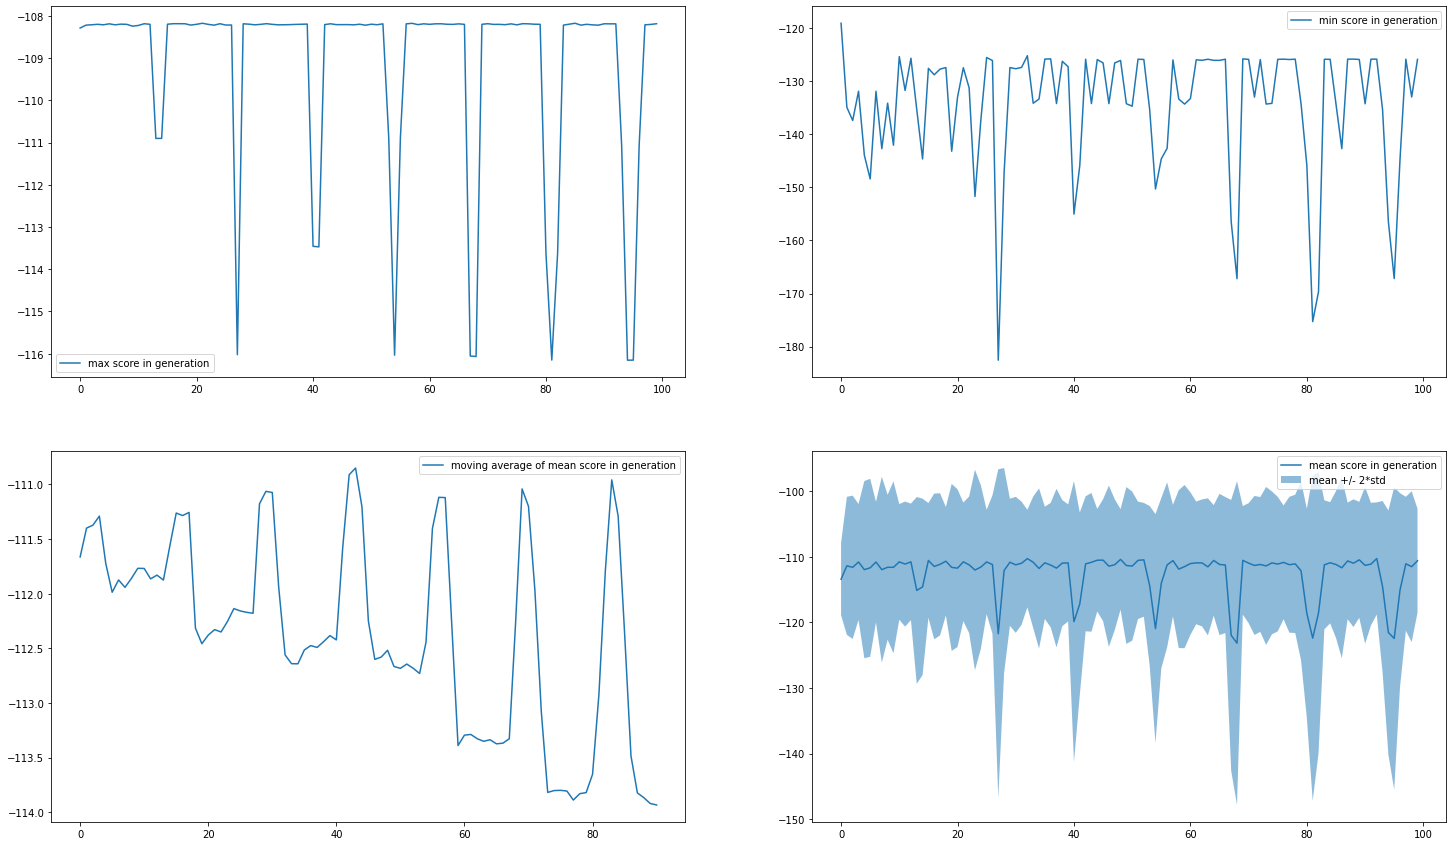

In [9]:
fig, axe = plt.subplots(2,2,figsize=(25,15))
axe[0,0].plot(pop.scores_per_generation["max"], label="max score in generation")
axe[0,0].legend()

axe[0,1].plot(pop.scores_per_generation["min"], label="min score in generation")
axe[0,1].legend()

axe[1,0].plot(np.convolve(pop.scores_per_generation["mean"], np.ones((10))/10, mode='valid'), label="moving average of mean score in generation")
axe[1,0].legend()

axe[1,1].plot(pop.scores_per_generation["mean"], label="mean score in generation")
axe[1,1].fill_between(np.arange(len(pop.scores_per_generation["mean"])), 
                      np.array(pop.scores_per_generation["mean"]) + 2 * np.array(pop.scores_per_generation["std"]), 
                      np.array(pop.scores_per_generation["mean"]) - 2 * np.array(pop.scores_per_generation["std"]), 
                      alpha = 0.5, label="mean +/- 2*std")
axe[1,1].legend()

In [0]:
tmp = [agent.reached_score for agent in pop.population]

In [11]:
torch.save(pop.population[np.argmax(tmp)], "agent_walker_100.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
